In [172]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp
import matplotlib.pyplot as plt
from PIL import Image

In [216]:
print(Dx.dot(U[0]))

[63. 63. 63. ... 63. 63. 63.]


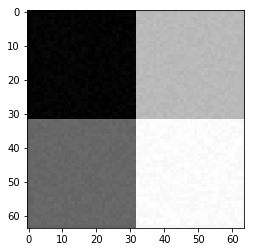

In [232]:
# Diffusion function
g = lambda s: 1/(1+s)
g_exp = lambda s: np.exp(-s**2)

f = lambda x, y: x + y

def generate_squares2D(N, M):
    I = np.zeros((N+2, M+2))
    I[:N//2+1, :M//2+1] = 80
    I[:N//2+1, -(M//2+1):] = 190
    I[-(N//2+1):, :M//2+1] = 140
    I[-(N//2+1):, -(M//2+1):] = 230
    return I

def add_noise2D(I, scale = 10):
    N, M = I.shape
    N -= 2
    M -= 2
    I[1:-1, 1:-1] += np.random.rand(N,M) * 5
    return I
    

# Create a random test image
def generate_random2D(N, M, scale = 10):
    # Generate image of 4 squares
    I = generate_squares2D(N, M)
    
    # Add noise to picture
#     I[1:-1, 1:-1] += np.random.rand(N,M) * 5
    add_noise2D(I)
    return I

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def image_display(V, n, m, cmap = "gray"):
    image = V.reshape((n, m))
    plt.imshow(image, cmap)
    plt.show()


# Spatial discretization
M = 62
N = 62
K = (M+2) * (N+2)
dx = 1/(M+1)
dy = 1/(N+1)


# Number of iteratinos, adn timestep
T = 1000
dt = 1e-10
r = dt/(2*(dx**2 + dy**2))

# Generate random image
I = generate_random2D(N, M)
# I = load_image("lena-64x64.jpg")


# Initiate grid
U = np.zeros((T, K))
U[0] = I.reshape(K)
# U[0] = f(*np.meshgrid(np.arange(N+2),np.arange(M+2))).reshape(K)

plt.imshow(U[0].reshape(N+2, M+2), cmap = "gray")
plt.show()

In [237]:
# Spatial discretization
M = 2
N = 2
K = (M+2) * (N+2)
dx = 1/(M+1)
dy = 1/(N+1)

# Initial conditions
I = generate_random2D(N, M, scale = 2)
# I = load_image("lena-64x64.jpg")


# Number of iterations, and timestep
T = 10000
dt = 1e-10
r = dt/(2*(dx**2 + dy**2))

# Block matrix x-derivative
Bx = -1 * np.eye(M+2, k = -1) + np.eye(M+2, k = 1)
Bx[0, :3] = [-3, 4, -1]
Bx[-1, -3:] = [1, -4, 3]

# Differentiation matrix x-direction
Dx = np.zeros((K, K))
for i in range(N+2):
    Dx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Bx  
Dx /= 2*dx

# Differentiation matrix y-direction
Dy = -np.eye(K, k = -(M+2)) + np.eye(K, k = M+2)
Dy[:(M+2), :3*(M+2)] = np.hstack((-3*np.identity(M+2), 4*np.identity(M+2), -np.identity(M+2)))
Dy[-(M+2):, -3*(M+2):] = np.hstack((np.identity(M+2), -4*np.identity(M+2), 3*np.identity(M+2)))
Dy /= 2*dy

Ξx = np.zeros((K, K))
Ωx = np.zeros((K, K))
Γx = np.zeros((K, K))

Ξy = np.zeros((K, K))
Ωy = np.zeros((K, K))
Γy = np.zeros((K, K))

#Block matrix for Ξx
Xx = np.eye(M+2, k = -1) + np.eye(M+2)
Xx[0, :2] = 0
Xx[-1, -2:] = 0

#Block matrix for Ωx
Mx = -np.eye(M+2, k = -1) -2*np.eye(M+2) - np.eye(M+2, k = 1)
Mx[0, :2] = 0
Mx[-1, -2:] = 0

#Block matrix for Γx
Fx = np.eye(M+2) + np.eye(M+2, k = 1)
Fx[0, :2] = 0
Fx[-1, -2:] = 0


# Fill in matrices
for i in range(1, N+1):
    Ξx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Xx

for i in range(1, N+1):
    Ωx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Mx

for i in range(1, N+1):
    Γx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Fx

for i in range(1, N+1):
    Ξy[i*(M+2)+1:(i+1)*(M+2)-1, (i-1)*(M+2)+1:i*(M+2)-1] = np.identity(M)
    Ξy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = np.identity(M)

for i in range(1, N+1):
    Ωy[i*(M+2)+1:(i+1)*(M+2)-1, (i-1)*(M+2)+1:i*(M+2)-1] = -np.identity(M)
    Ωy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = -2*np.identity(M)
    Ωy[i*(M+2)+1:(i+1)*(M+2)-1, (i+1)*(M+2)+1:(i+2)*(M+2)-1] = -np.identity(M)

for i in range(1, N+1):
    Γy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = np.identity(M)
    Γy[i*(M+2)+1:(i+1)*(M+2)-1, (i+1)*(M+2)+1:(i+2)*(M+2)-1] = np.identity(M)

In [244]:
for i in range(K):
    print(np.round(Ωy[i]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0. -1. -0.  0.  0. -2. -0.  0.  0. -1. -0.  0.  0.  0.  0.  0.]
[ 0. -0. -1.  0.  0. -0. -2.  0.  0. -0. -1.  0.  0.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0. -1. -0.  0.  0. -2. -0.  0.  0. -1. -0.  0.]
[ 0.  0.  0.  0.  0. -0. -1.  0.  0. -0. -2.  0.  0. -0. -1.  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


0


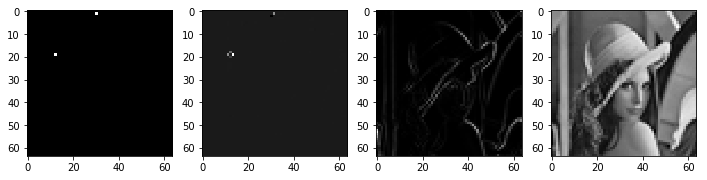

10


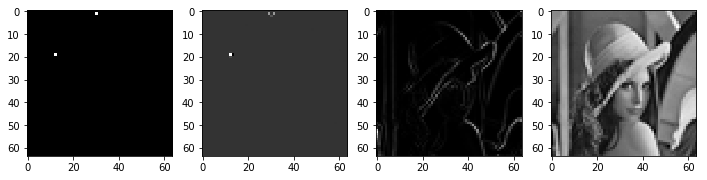

20


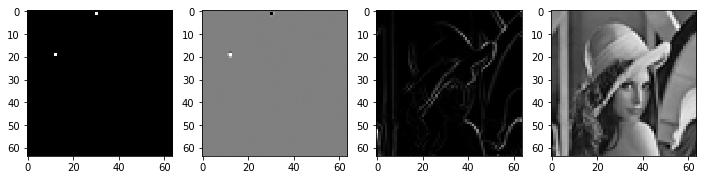

30


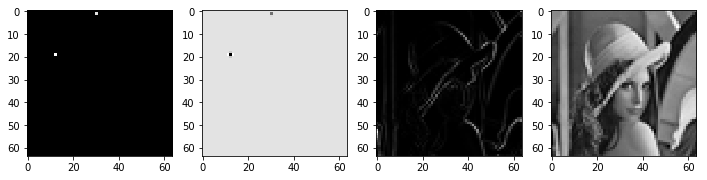

40


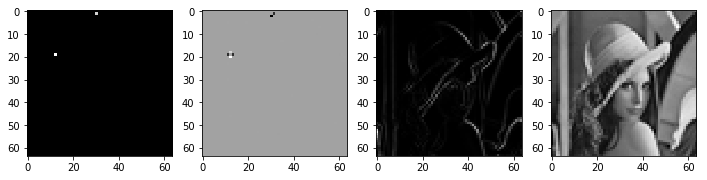

50


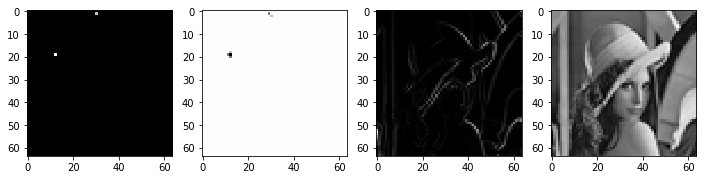

60


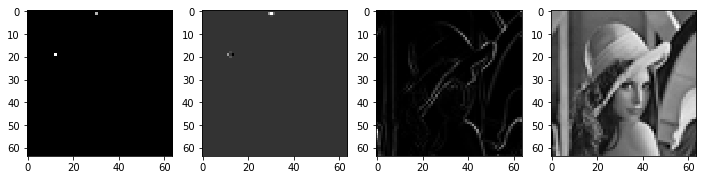

70


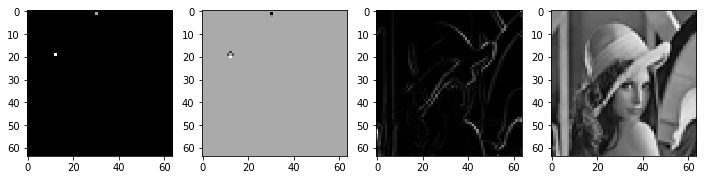

80


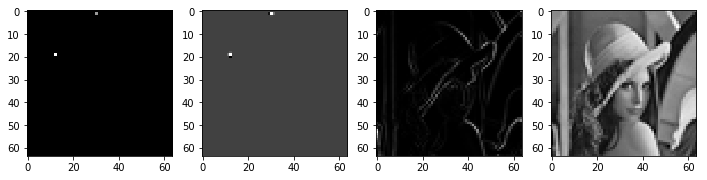

90


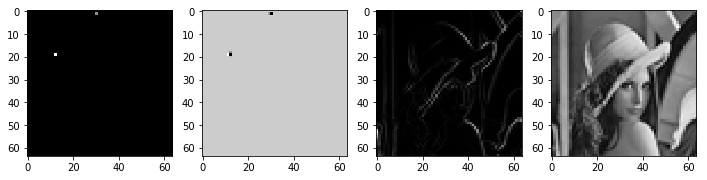

100


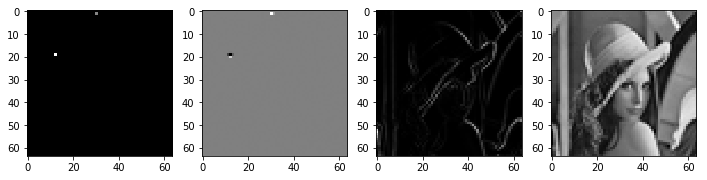

110


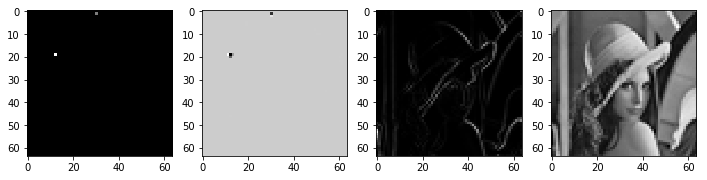

120


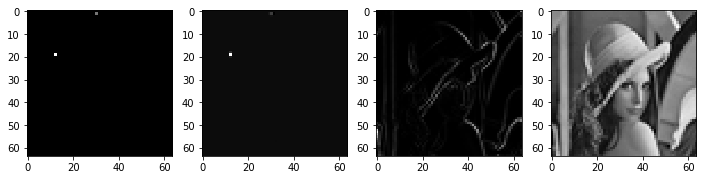

130


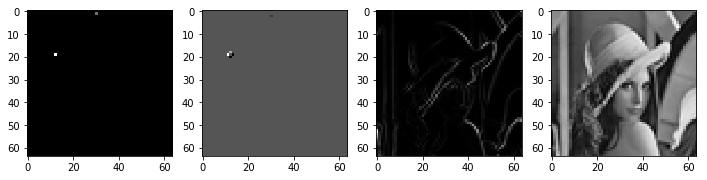

140


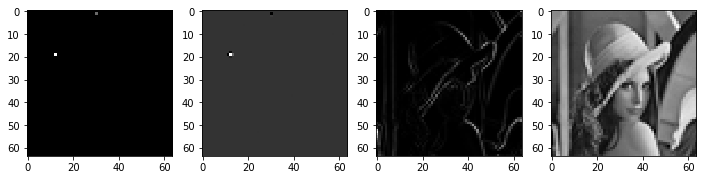

150


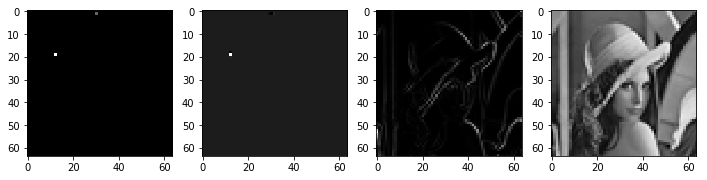

160


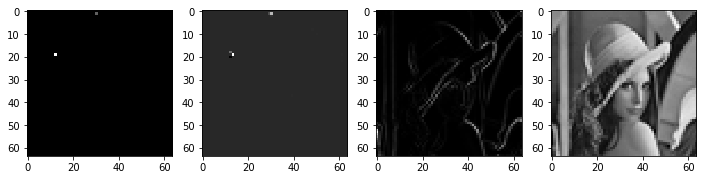

170


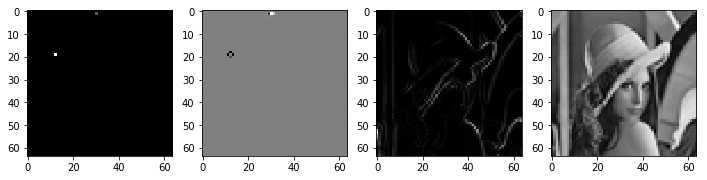

180


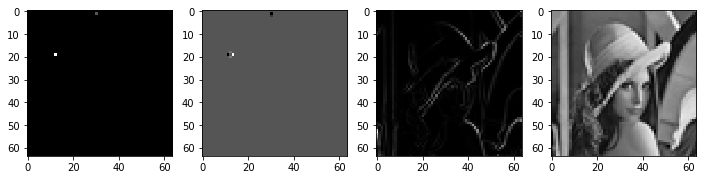

190


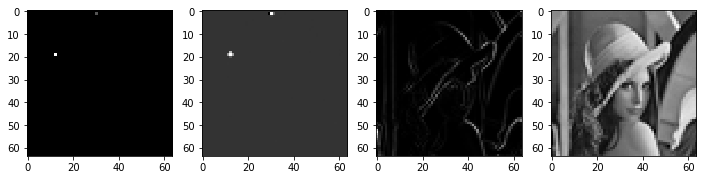

200


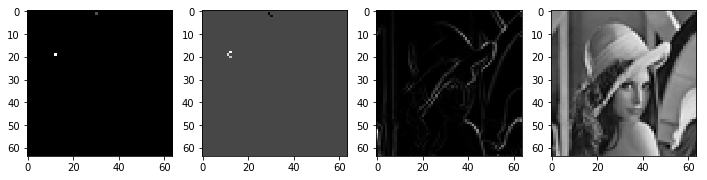

210


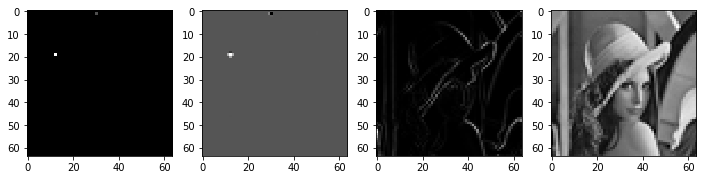

220


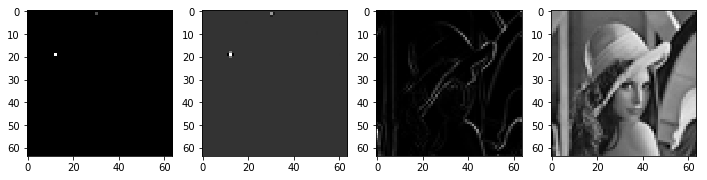

230


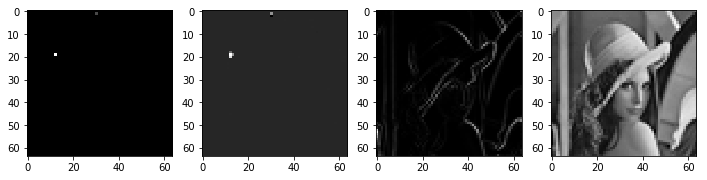

240


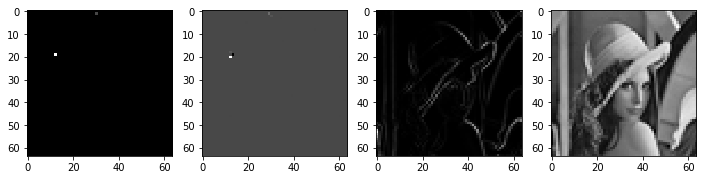

250


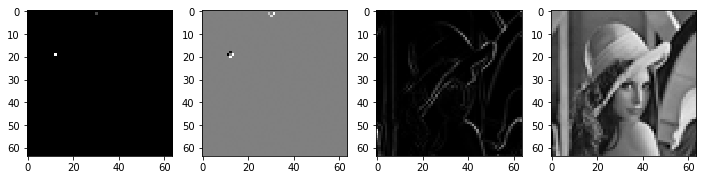

260


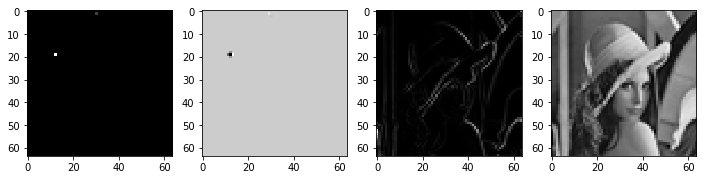

270


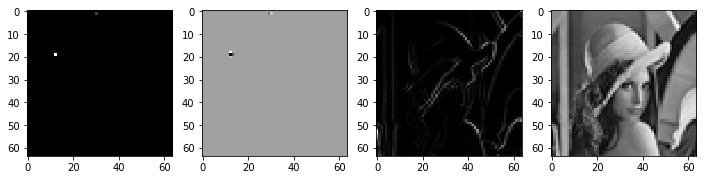

280


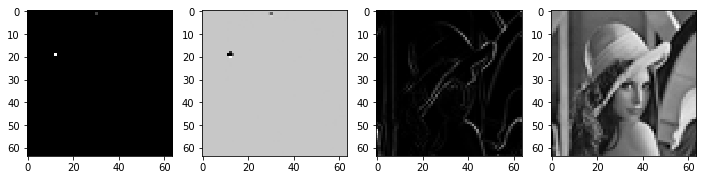

290


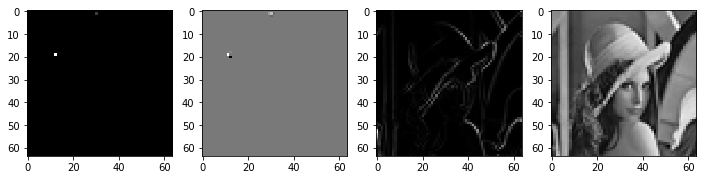

300


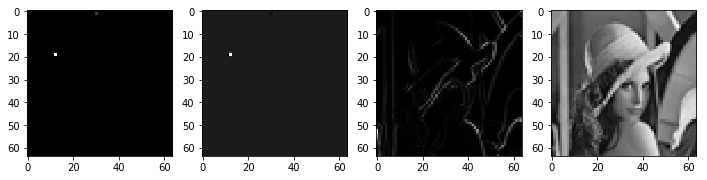

310


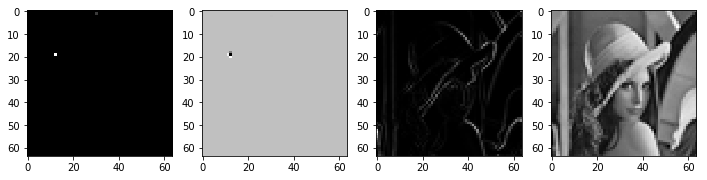

320


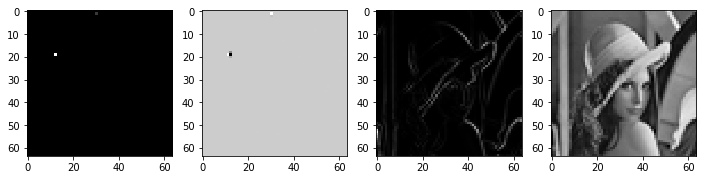

330


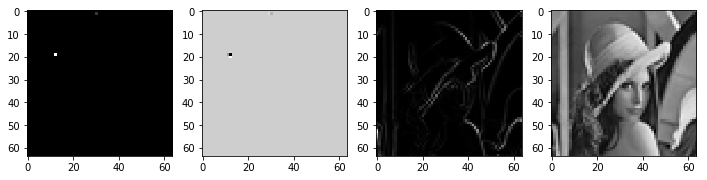

340


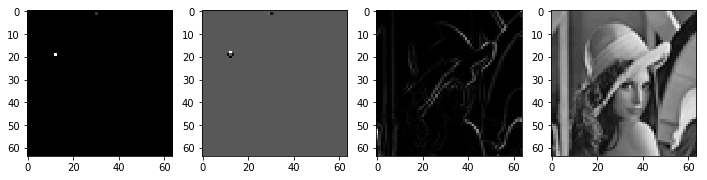

350


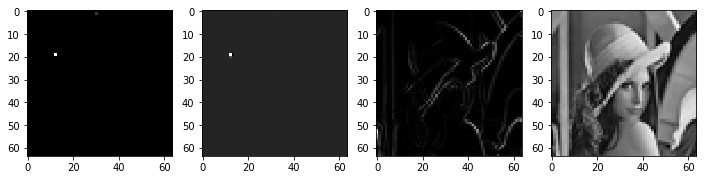

360


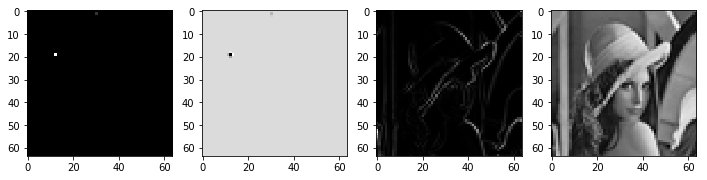

370


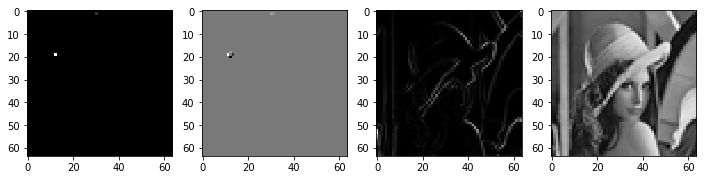

380


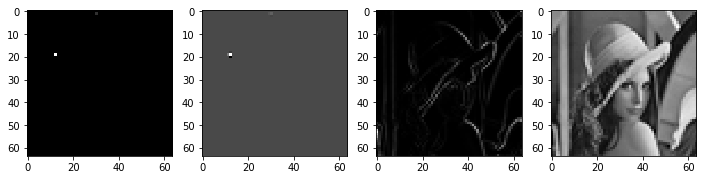

390


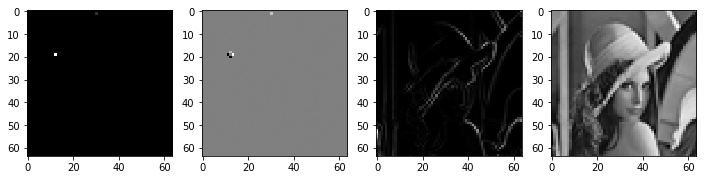

400


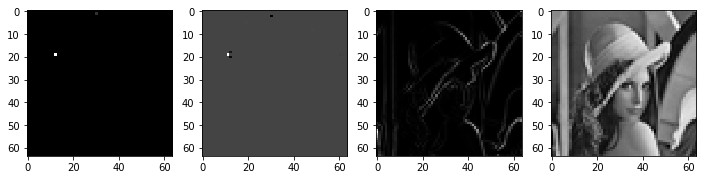

410


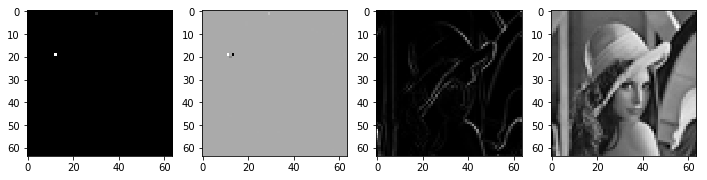

420


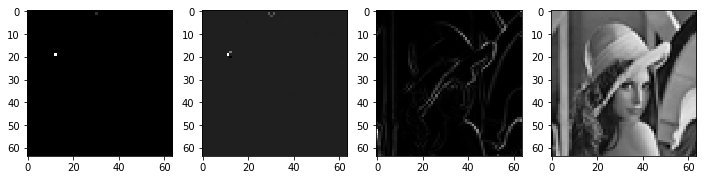

430


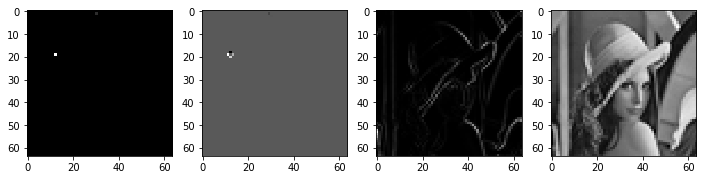

440


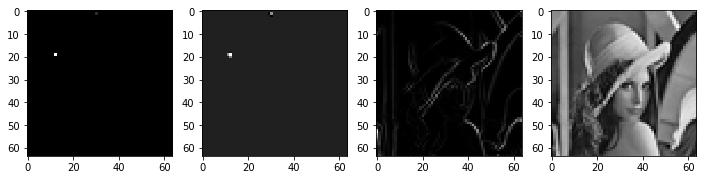

450


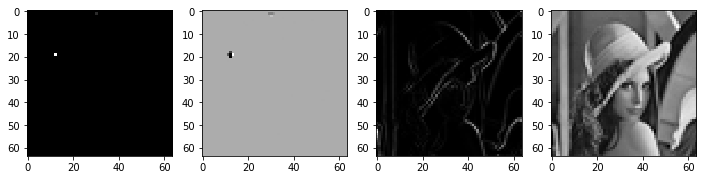

460


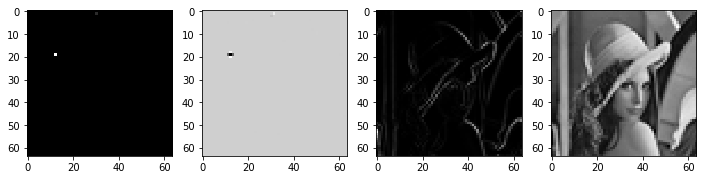

470


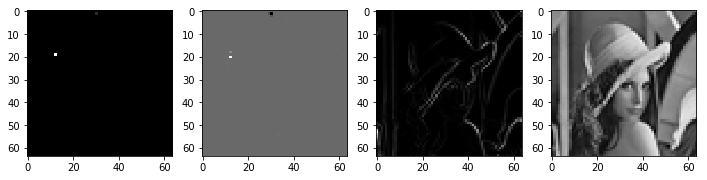

480


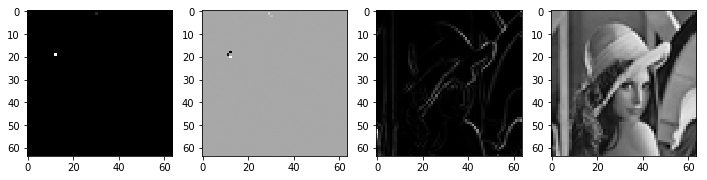

490


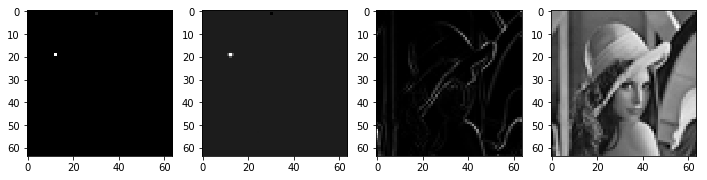

500


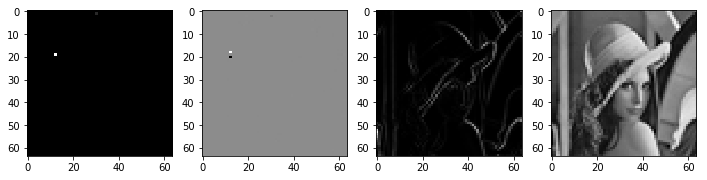

510


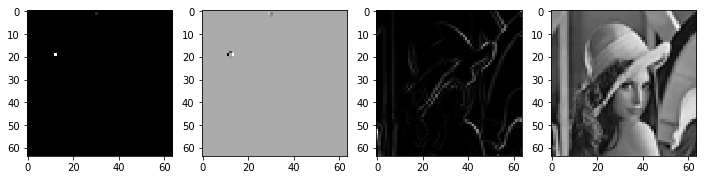

520


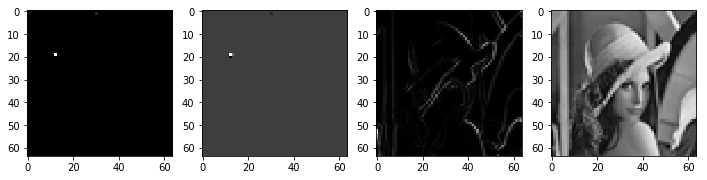

530


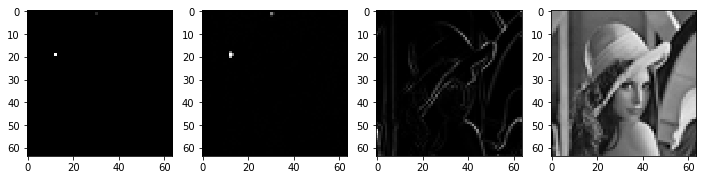

540


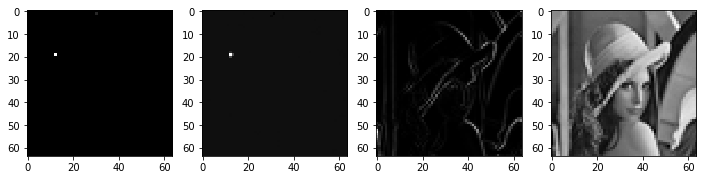

550


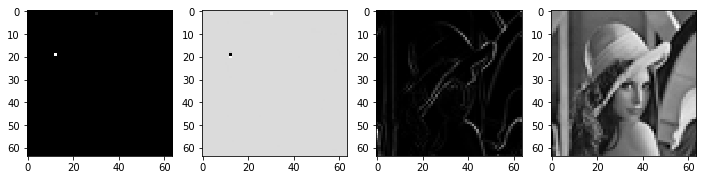

560


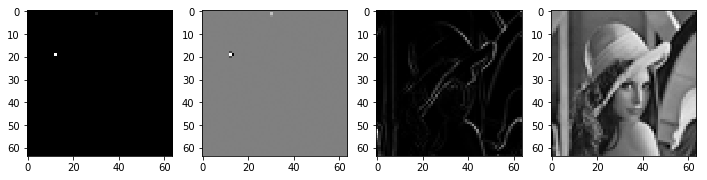

570


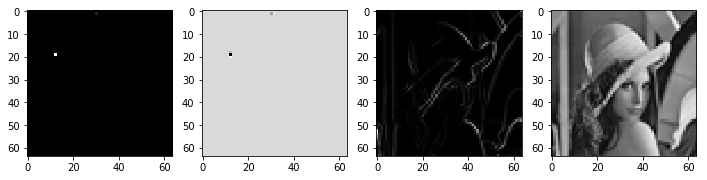

580


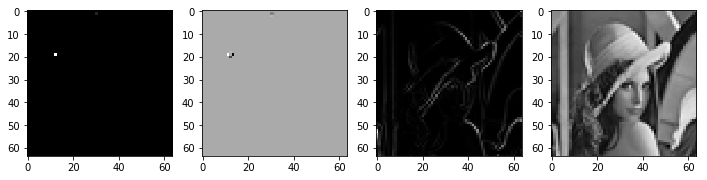

590


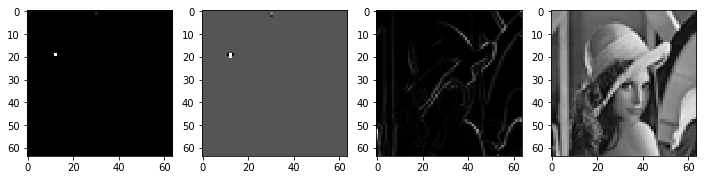

600


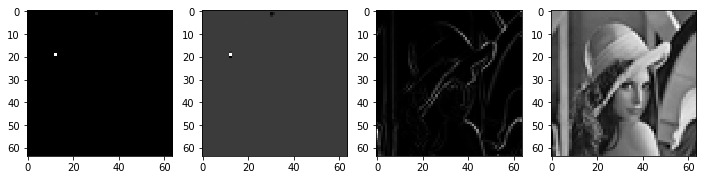

610


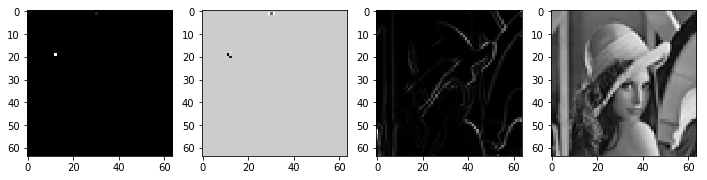

620


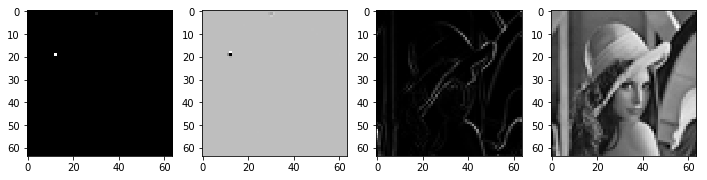

630


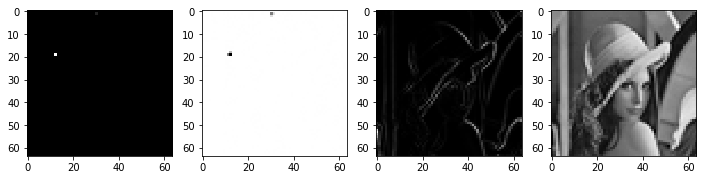

640


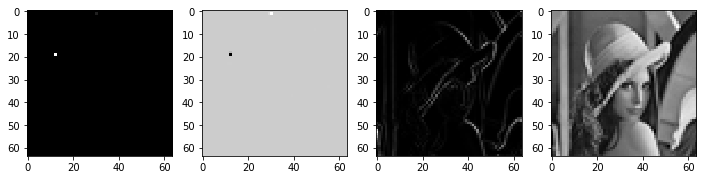

650


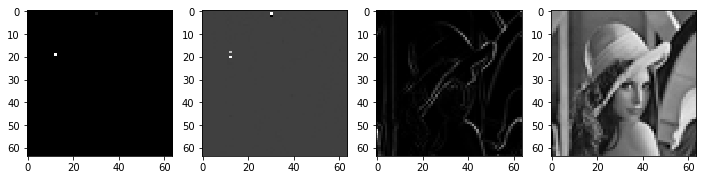

660


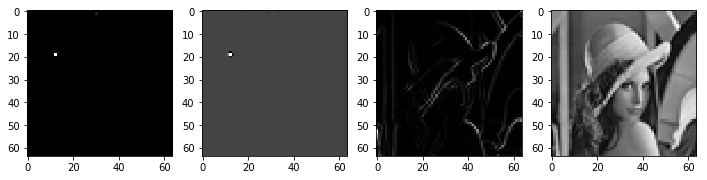

670


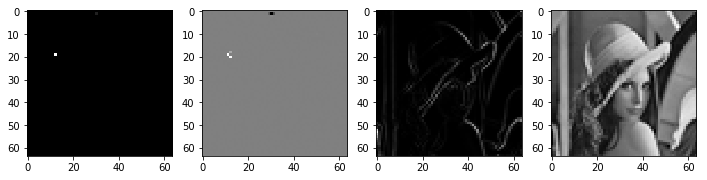

KeyboardInterrupt: 

In [185]:
# Initiate grid
U = np.zeros((T, K))
U[0] = I.reshape(K)

# Display initial conditinos
# plt.imshow(U[0].reshape(N+2, M+2), cmap = "gray")
# plt.show()

# Perform iterations
for it in range(T-1):
    G = g(Dx.dot(U[it])**2 + Dy.dot(U[it])**2)
        
    ξx = Ξx.dot(G)
    ωx = Ωx.dot(G)
    γx = Γx.dot(G)

    ξy = Ξy.dot(G)
    ωy = Ωy.dot(G)
    γy = Γy.dot(G)
    
    # Construct scheme matrix
    x_diags = (ξx[1:], ωx, γx[:-1])
    y_diags = (ξy[(M+2):], ωy, γy[:-(M+2)])
    Ax = spsp.diags(x_diags, (-1, 0, 1)).toarray()/(2*dx**2)
    Ay = spsp.diags(y_diags, (-(M+2), 0, M+2)).toarray()/(2*dy**2)
    A = Ax + Ay
    
    U[it+1] = (np.identity(K) - r * A).dot(U[it])
    
    # Debug
    if it%10 == 0:
        print(it)
        plt.figure(figsize=(12, 8))
        plt.subplot(141)
        plt.imshow(G.reshape(N+2, M+2), cmap = "gray")
        plt.subplot(142)
        plt.imshow(A.dot(np.ones(K)).reshape(N+2, M+2), cmap = "gray")#A.dot(U[it]).reshape(N+2, M+2), cmap = "gray")
        plt.subplot(143)
        plt.imshow((Dy.dot(U[0])**2 + Dx.dot(U[0])**2).reshape(N+2, M+2), cmap = "gray")
        plt.subplot(144)
        plt.imshow(U[it].reshape(N+2, M+2), cmap = "gray")
        plt.show()

In [181]:
np.argmax(np.abs(U[0]-U[-1]))

417

In [143]:
np.argmax(G)
print(1228//(M+2), 1228 - (M+2)*(1228//(M+2)))


print(U[0].reshape(N+2, M+2)[17:22, 10:15])


19 12
[[68. 67. 68. 72. 74.]
 [66. 63. 65. 68. 78.]
 [66. 65. 65. 65. 80.]
 [65. 64. 65. 61. 84.]
 [64. 63. 64. 57. 88.]]


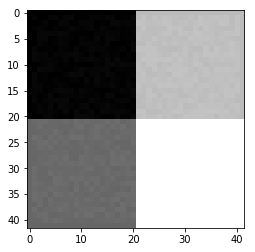

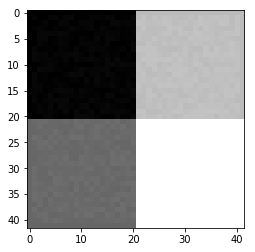

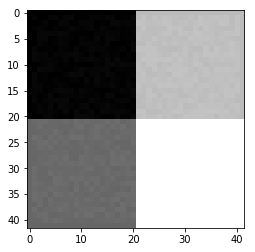

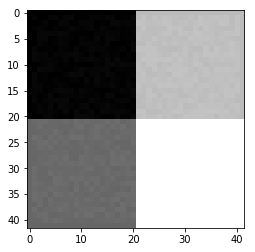

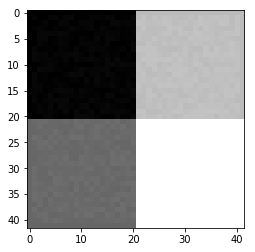

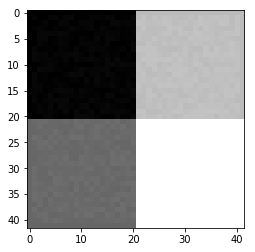

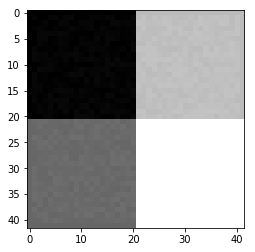

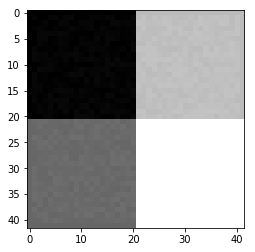

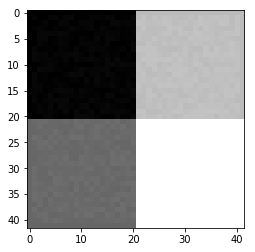

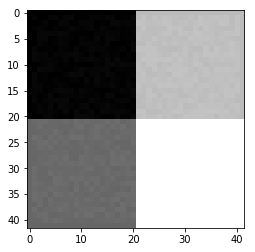

In [107]:
U[U[:] > 230] = 230
U[U[:] < 80] = 80
for i in range(10):
    plt.figure()#figsize=(12,8))
    plt.imshow(U[i*T//11].reshape(N+2, M+2), cmap = "gray")
    plt.show()

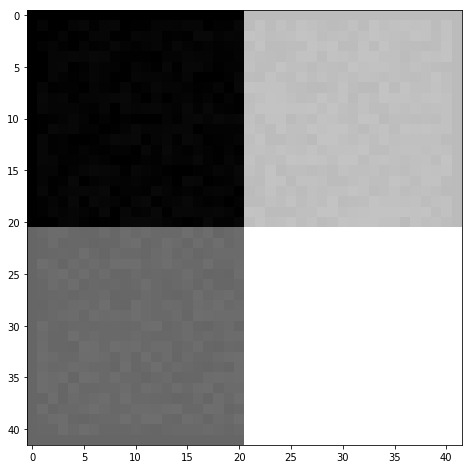

In [108]:
plt.figure(figsize =(12,8))
plt.imshow(U[-1].reshape(N+2, M+2), cmap = "gray")
plt.show()